DENSENET_SEED_999


In [1]:
# For reproducibility with CuBLAS
import os
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":16:8"

In [2]:
import re
import random
import textwrap

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import cv2
from PIL import Image
from tqdm import tqdm
from typing import List, Optional, Tuple, Dict

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms
import torchvision.models as models

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, multilabel_confusion_matrix

import pickle
import numpy as np

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [4]:
os.getcwd()

'/content'

In [5]:
import kagglehub

path = kagglehub.dataset_download("snikhilrao/chexlocalize-dataset")
print("Path to dataset files:", path)


100%|██████████| 2.83G/2.83G [00:31<00:00, 95.2MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/snikhilrao/chexlocalize-dataset/versions/1


In [6]:
!ls /root/.cache/kagglehub/datasets/snikhilrao/chexlocalize-dataset/versions/1


chexlocalize_dataset


In [7]:
base = "/root/.cache/kagglehub/datasets/snikhilrao/chexlocalize-dataset/versions/1/chexlocalize_dataset/chexlocalize/CheXlocalize/gradcam_maps_val"


In [8]:
import os

for f in os.listdir(base):
    print(f)


patient64681_study1_view1_frontal_Pleural Effusion_map.pkl
patient64726_study1_view1_frontal_Support Devices_map.pkl
patient64546_study1_view1_frontal_Airspace Opacity_map.pkl
patient64580_study1_view1_frontal_Consolidation_map.pkl
patient64566_study1_view2_lateral_Pleural Effusion_map.pkl
patient64589_study1_view1_frontal_Atelectasis_map.pkl
patient64719_study1_view1_frontal_Airspace Opacity_map.pkl
patient64547_study1_view1_frontal_Consolidation_map.pkl
patient64705_study1_view1_frontal_Cardiomegaly_map.pkl
patient64583_study1_view1_frontal_Atelectasis_map.pkl
patient64661_study1_view1_frontal_Support Devices_map.pkl
patient64739_study1_view1_frontal_Enlarged Cardiomediastinum_map.pkl
patient64736_study1_view1_frontal_Pneumothorax_map.pkl
patient64594_study1_view2_lateral_Atelectasis_map.pkl
patient64592_study1_view1_frontal_Cardiomegaly_map.pkl
patient64705_study1_view2_lateral_Support Devices_map.pkl
patient64581_study1_view2_frontal_Pleural Effusion_map.pkl
patient64562_study1_vie

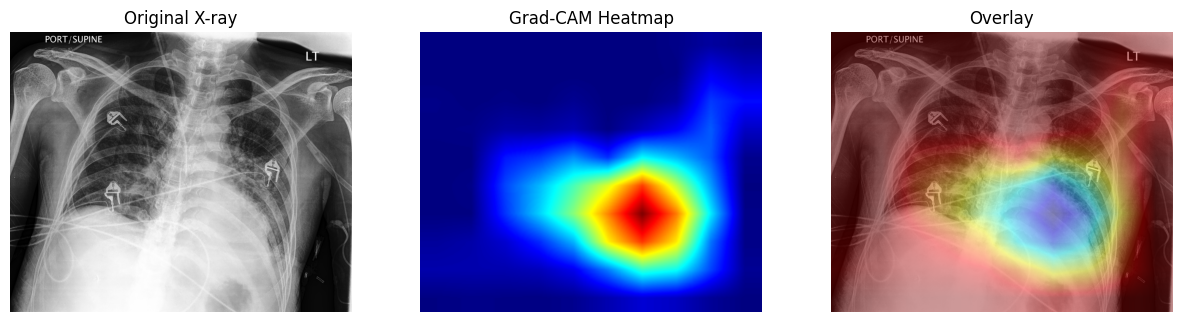

In [9]:
import os
import pickle
import numpy as np
import cv2
import matplotlib.pyplot as plt

# 1. paths
heatmap_folder = "/root/.cache/kagglehub/datasets/snikhilrao/chexlocalize-dataset/versions/1/chexlocalize_dataset/chexlocalize/CheXlocalize/gradcam_maps_val"
image_folder = "/root/.cache/kagglehub/datasets/snikhilrao/chexlocalize-dataset/versions/1/chexlocalize_dataset/chexlocalize/CheXpert/val/patient64669/study1"
heatmap_file = "patient64669_study1_view1_frontal_Airspace Opacity_map.pkl"
image_file   = "view1_frontal.jpg"

pkl_path = os.path.join(heatmap_folder, heatmap_file)
img_path = os.path.join(image_folder, image_file)

# 2. load image
orig = cv2.imread(img_path)
orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)

# 3. load heatmap
with open(pkl_path, "rb") as f:
    data = pickle.load(f)

arr = next(iter(data.values())) if isinstance(data, dict) else data
arr = np.squeeze(np.array(arr))  # (1,1,320,320) -> (320,320)

# 4. normalize + color
arr_norm = (arr - arr.min()) / (arr.max() - arr.min() + 1e-8)
arr_uint8 = (arr_norm * 255).astype(np.uint8)
heatmap = cv2.applyColorMap(arr_uint8, cv2.COLORMAP_JET)

# 5. resize
heatmap_resized = cv2.resize(heatmap, (orig.shape[1], orig.shape[0]))

# 6. overlay
overlay = cv2.addWeighted(orig, 0.6, heatmap_resized, 0.4, 0)

# 7. show everything
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.imshow(orig)
plt.title("Original X-ray")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(cv2.cvtColor(heatmap_resized, cv2.COLOR_BGR2RGB))
plt.title("Grad-CAM Heatmap")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(overlay)
plt.title("Overlay")
plt.axis("off")

plt.show()


In [11]:
import torchvision.models as models
import torch.nn as nn
import torch

num_classes = 8

model = models.densenet121(weights=None)
in_features = model.classifier.in_features

# Recreate EXACT classifier used in training
model.classifier = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(in_features, num_classes)
)

checkpoint = torch.load("/content/densenet_seed999_best_model.pth", map_location="cpu")

# Load the weights
model.load_state_dict(checkpoint["model_state_dict"], strict=True)

model.eval()
print("DenseNet Loaded ✓ (with correct classifier)")


DenseNet Loaded ✓ (with correct classifier)


In [12]:
import os
import pickle
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
from torchvision import transforms
from tqdm import tqdm


# -----------------------------
# Image transform
# -----------------------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])


# ---------------------------------------------------------
# Explainability metrics (NO masks needed)
# ---------------------------------------------------------

def average_drop(orig_score, masked_score):
    return max(0, (orig_score - masked_score) / (orig_score + 1e-6))

def increase_in_conf(orig_score, masked_score):
    return max(0, (masked_score - orig_score) / (orig_score + 1e-6))

def heatmap_entropy(hm):
    hm = hm / (hm.sum() + 1e-6)
    return -np.sum(hm * np.log(hm + 1e-10))

def heatmap_sparsity(hm):
    return 1 - (np.count_nonzero(hm) / hm.size)

def deletion_metric(model, img, hm, steps=30):
    scores = []
    img = img.clone()
    flat = hm.flatten()
    order = np.argsort(-flat)
    mask = torch.ones_like(img)

    for step in range(steps):
        k = int((step + 1) / steps * len(order))

        mask_flat = mask.view(-1)
        mask_flat[order[:k]] = 0
        mask = mask_flat.view_as(mask)

        new_img = img * mask
        with torch.no_grad():
            out = model(new_img.unsqueeze(0))
        scores.append(out.max().item())

    return scores


def insertion_metric(model, img, hm, steps=30):
    scores = []
    blurred = torch.zeros_like(img)
    flat = hm.flatten()
    order = np.argsort(-flat)
    mask = torch.zeros_like(img)

    for step in range(steps):
        k = int((step + 1) / steps * len(order))

        mask_flat = mask.view(-1)
        mask_flat[order[:k]] = 1
        mask = mask_flat.view_as(mask)

        new_img = blurred * (1 - mask) + img * mask

        with torch.no_grad():
            out = model(new_img.unsqueeze(0))
        scores.append(out.max().item())

    return scores


In [13]:
HEATMAP_ROOT = "/root/.cache/kagglehub/datasets/snikhilrao/chexlocalize-dataset/versions/1/chexlocalize_dataset/chexlocalize/CheXlocalize/gradcam_maps_val"

IMAGE_ROOT   = "/root/.cache/kagglehub/datasets/snikhilrao/chexlocalize-dataset/versions/1/chexlocalize_dataset/chexlocalize/CheXpert/val"


In [14]:
results = []

for patient in tqdm(os.listdir(IMAGE_ROOT)):
    patient_path = os.path.join(IMAGE_ROOT, patient)
    if not patient.startswith("patient"):
        continue

    study_folder = os.path.join(patient_path, "study1")
    img_path = os.path.join(study_folder, "view1_frontal.jpg")

    if not os.path.exists(img_path):
        continue

    heatmap_file = f"{patient}_study1_view1_frontal_Airspace Opacity_map.pkl"
    heatmap_path = os.path.join(HEATMAP_ROOT, heatmap_file)

    if not os.path.exists(heatmap_path):
        continue

    # ---------------------------------------
    # Load image & DenseNet prediction
    # ---------------------------------------
    img = Image.open(img_path).convert("RGB")
    img_t = transform(img).float()

    with torch.no_grad():
        orig_out = model(img_t.unsqueeze(0))
    orig_score = orig_out.max().item()

    # ---------------------------------------
    # Load heatmap (.pkl)
    # ---------------------------------------
    with open(heatmap_path, "rb") as f:
        d = pickle.load(f)

    hm = d["map"]

    # Tensor → NumPy
    if torch.is_tensor(hm):
        hm = hm.detach().cpu().numpy()

    # Remove dims (1,1,H,W → H,W)
    while hm.ndim > 2:
        hm = hm.squeeze()

    hm = hm.astype(float)

    # Normalize 0–1
    hm = (hm - hm.min()) / (hm.max() - hm.min() + 1e-6)

    # Resize to 224×224
    hm = np.array(
        Image.fromarray((hm * 255).astype("uint8")).resize((224, 224))
    ) / 255.0

    # Convert to tensor (1,H,W)
    hm_t = torch.tensor(hm, dtype=torch.float32).unsqueeze(0)

    # ---------------------------------------
    # Masked image (keep only Grad-CAM area)
    # ---------------------------------------
    masked_img = img_t * hm_t

    with torch.no_grad():
        masked_out = model(masked_img.unsqueeze(0).float())
    masked_score = masked_out.max().item()

    # ---------------------------------------
    # Compute metrics
    # ---------------------------------------
    metrics = {
        "patient": patient,
        "avg_drop": average_drop(orig_score, masked_score),
        "inc_conf": increase_in_conf(orig_score, masked_score),
        "entropy": heatmap_entropy(hm),
        "sparsity": heatmap_sparsity(hm),
        "deletion": deletion_metric(model, img_t, hm),
        "insertion": insertion_metric(model, img_t, hm)
    }

    results.append(metrics)


100%|██████████| 200/200 [39:38<00:00, 11.89s/it]


In [15]:
import pandas as pd

df = pd.DataFrame(results)
df.to_pickle("densenet_explainability_results.pkl")
df.to_csv("densenet_explainability_results.csv", index=False)

print("\nSaved:")
print(df.head())



Saved:
        patient  avg_drop  inc_conf    entropy  sparsity  \
0  patient64669  0.474733         0   9.984005  0.199956   
1  patient64712  0.485205         0  10.126024  0.155931   
2  patient64638  0.508190         0  10.234657  0.112663   
3  patient64707  0.503903         0   9.649798  0.478815   
4  patient64715  0.493116         0  10.212607  0.092056   

                                            deletion  \
0  [8.75818157196045, 8.86020565032959, 8.9975786...   
1  [9.050609588623047, 8.998549461364746, 8.94362...   
2  [8.441399574279785, 8.45926570892334, 8.806916...   
3  [10.399107933044434, 10.076386451721191, 10.25...   
4  [8.464386940002441, 8.84782886505127, 9.232910...   

                                           insertion  
0  [5.057775497436523, 5.096463680267334, 5.37796...  
1  [4.8573994636535645, 5.3207879066467285, 5.543...  
2  [4.788311958312988, 5.247677803039551, 6.06809...  
3  [4.863789081573486, 5.069015026092529, 5.55229...  
4  [5.3877711296081

In [16]:
import numpy as np
import pandas as pd

df = pd.DataFrame(results)

# ----------------------------
# 1. Scalar metrics aggregated
# ----------------------------
summary = {
    "avg_drop_mean":     df["avg_drop"].mean(),
    "avg_drop_std":      df["avg_drop"].std(),
    "inc_conf_mean":     df["inc_conf"].mean(),
    "inc_conf_std":      df["inc_conf"].std(),
    "entropy_mean":      df["entropy"].mean(),
    "entropy_std":       df["entropy"].std(),
    "sparsity_mean":     df["sparsity"].mean(),
    "sparsity_std":      df["sparsity"].std(),
}

# ----------------------------
# 2. Deletion & insertion curves
# ----------------------------
# Convert list-of-lists → 2D array: shape (N_patients, N_steps)
deletion_array = np.stack(df["deletion"].values)
insertion_array = np.stack(df["insertion"].values)

summary["deletion_curve_mean"] = deletion_array.mean(axis=0).tolist()
summary["insertion_curve_mean"] = insertion_array.mean(axis=0).tolist()

summary["deletion_curve_std"] = deletion_array.std(axis=0).tolist()
summary["insertion_curve_std"] = insertion_array.std(axis=0).tolist()

# Save summary
import json
with open("explainability_dataset_summary.json", "w") as f:
    json.dump(summary, f, indent=4)

print("===== DATASET-LEVEL SUMMARY =====")
for k, v in summary.items():
    if isinstance(v, float):
        print(f"{k}: {v:.5f}")
    else:
        print(f"{k}: (vector length {len(v)})")



===== DATASET-LEVEL SUMMARY =====
avg_drop_mean: 0.44938
avg_drop_std: 0.06945
inc_conf_mean: 0.00000
inc_conf_std: 0.00000
entropy_mean: 10.02331
entropy_std: 0.30369
sparsity_mean: 0.20718
sparsity_std: 0.15163
deletion_curve_mean: (vector length 30)
insertion_curve_mean: (vector length 30)
deletion_curve_std: (vector length 30)
insertion_curve_std: (vector length 30)


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1864: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Predicted class index: 0


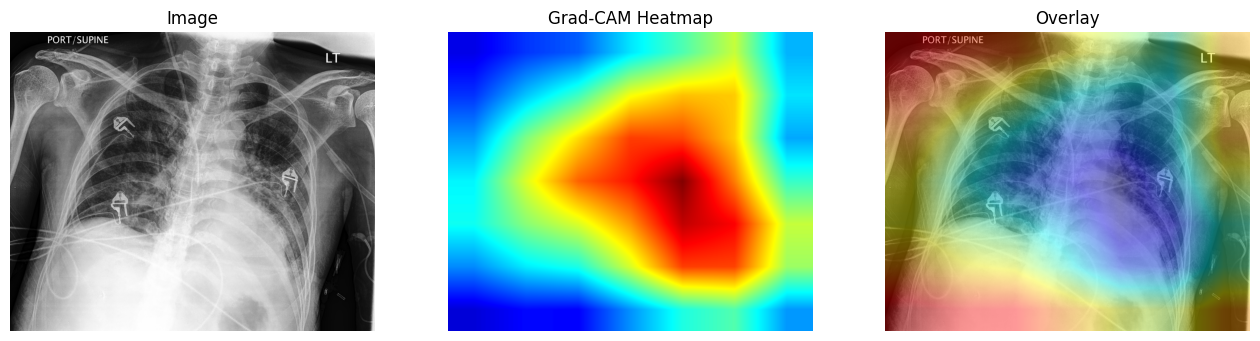

In [19]:
import cv2
import numpy as np
import torch
from torchvision import transforms
import matplotlib.pyplot as plt

# ---------------------------
# Correct full image path
# ---------------------------
img_path = "/root/.cache/kagglehub/datasets/snikhilrao/chexlocalize-dataset/versions/1/chexlocalize_dataset/chexlocalize/CheXpert/val/patient64669/study1/view1_frontal.jpg"

# ---------------------------
# Load image
# ---------------------------
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

tensor_img = transform(img).unsqueeze(0)

# ---------------------------
# Grad-CAM hook
# ---------------------------
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.gradients = None
        self.activations = None

        target_layer.register_forward_hook(self.forward_hook)
        target_layer.register_backward_hook(self.backward_hook)

    def forward_hook(self, module, input, output):
        self.activations = output

    def backward_hook(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def generate(self, class_idx):
        grads = self.gradients.mean(dim=[2, 3], keepdim=True)

        cams = (grads * self.activations).sum(dim=1)[0]
        cams = torch.relu(cams)
        cams = cams / (cams.max() + 1e-8)
        return cams.detach().cpu().numpy()

# ---------------------------
# DENSENET TARGET LAYER
# ---------------------------
# IMPORTANT: DenseNet uses features.denseblock4
target_layer = model.features.denseblock4

cam = GradCAM(model, target_layer)

# ---------------------------
# Forward → Predict class
# ---------------------------
output = model(tensor_img)
class_idx = output.argmax().item()
print("Predicted class index:", class_idx)

# ---------------------------
# Backward on predicted class
# ---------------------------
model.zero_grad()
output[0, class_idx].backward()

heatmap = cam.generate(class_idx)

# ---------------------------
# Make heatmap visible
# ---------------------------
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap_vis = np.uint8(255 * heatmap)
heatmap_vis = cv2.applyColorMap(heatmap_vis, cv2.COLORMAP_JET)

overlay = cv2.addWeighted(img, 0.6, heatmap_vis, 0.4, 0)

# ---------------------------
# Show results
# ---------------------------
plt.figure(figsize=(16,5))

plt.subplot(1,3,1)
plt.imshow(img)
plt.title("Image")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(cv2.cvtColor(heatmap_vis, cv2.COLOR_BGR2RGB))
plt.title("Grad-CAM Heatmap")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(overlay)
plt.title("Overlay")
plt.axis("off")

plt.show()


SEED 123

In [22]:
import torchvision.models as models
import torch.nn as nn
import torch

num_classes = 8

model = models.densenet121(weights=None)
in_features = model.classifier.in_features

# Recreate EXACT classifier used in training
model.classifier = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(in_features, num_classes)
)

checkpoint = torch.load("/content/densenet_seed_123_best_model.pth", map_location="cpu")

# Load the weights
model.load_state_dict(checkpoint["model_state_dict"], strict=True)

model.eval()
print("DenseNet Loaded ✓ (with correct classifier)")


DenseNet Loaded ✓ (with correct classifier)


In [23]:
import os
import pickle
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
from torchvision import transforms
from tqdm import tqdm


# -----------------------------
# Image transform
# -----------------------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])


# ---------------------------------------------------------
# Explainability metrics (NO masks needed)
# ---------------------------------------------------------

def average_drop(orig_score, masked_score):
    return max(0, (orig_score - masked_score) / (orig_score + 1e-6))

def increase_in_conf(orig_score, masked_score):
    return max(0, (masked_score - orig_score) / (orig_score + 1e-6))

def heatmap_entropy(hm):
    hm = hm / (hm.sum() + 1e-6)
    return -np.sum(hm * np.log(hm + 1e-10))

def heatmap_sparsity(hm):
    return 1 - (np.count_nonzero(hm) / hm.size)

def deletion_metric(model, img, hm, steps=30):
    scores = []
    img = img.clone()
    flat = hm.flatten()
    order = np.argsort(-flat)
    mask = torch.ones_like(img)

    for step in range(steps):
        k = int((step + 1) / steps * len(order))

        mask_flat = mask.view(-1)
        mask_flat[order[:k]] = 0
        mask = mask_flat.view_as(mask)

        new_img = img * mask
        with torch.no_grad():
            out = model(new_img.unsqueeze(0))
        scores.append(out.max().item())

    return scores


def insertion_metric(model, img, hm, steps=30):
    scores = []
    blurred = torch.zeros_like(img)
    flat = hm.flatten()
    order = np.argsort(-flat)
    mask = torch.zeros_like(img)

    for step in range(steps):
        k = int((step + 1) / steps * len(order))

        mask_flat = mask.view(-1)
        mask_flat[order[:k]] = 1
        mask = mask_flat.view_as(mask)

        new_img = blurred * (1 - mask) + img * mask

        with torch.no_grad():
            out = model(new_img.unsqueeze(0))
        scores.append(out.max().item())

    return scores


In [24]:
results = []

for patient in tqdm(os.listdir(IMAGE_ROOT)):
    patient_path = os.path.join(IMAGE_ROOT, patient)
    if not patient.startswith("patient"):
        continue

    study_folder = os.path.join(patient_path, "study1")
    img_path = os.path.join(study_folder, "view1_frontal.jpg")

    if not os.path.exists(img_path):
        continue

    heatmap_file = f"{patient}_study1_view1_frontal_Airspace Opacity_map.pkl"
    heatmap_path = os.path.join(HEATMAP_ROOT, heatmap_file)

    if not os.path.exists(heatmap_path):
        continue

    # ---------------------------------------
    # Load image & DenseNet prediction
    # ---------------------------------------
    img = Image.open(img_path).convert("RGB")
    img_t = transform(img).float()

    with torch.no_grad():
        orig_out = model(img_t.unsqueeze(0))
    orig_score = orig_out.max().item()

    # ---------------------------------------
    # Load heatmap (.pkl)
    # ---------------------------------------
    with open(heatmap_path, "rb") as f:
        d = pickle.load(f)

    hm = d["map"]

    # Tensor → NumPy
    if torch.is_tensor(hm):
        hm = hm.detach().cpu().numpy()

    # Remove dims (1,1,H,W → H,W)
    while hm.ndim > 2:
        hm = hm.squeeze()

    hm = hm.astype(float)

    # Normalize 0–1
    hm = (hm - hm.min()) / (hm.max() - hm.min() + 1e-6)

    # Resize to 224×224
    hm = np.array(
        Image.fromarray((hm * 255).astype("uint8")).resize((224, 224))
    ) / 255.0

    # Convert to tensor (1,H,W)
    hm_t = torch.tensor(hm, dtype=torch.float32).unsqueeze(0)

    # ---------------------------------------
    # Masked image (keep only Grad-CAM area)
    # ---------------------------------------
    masked_img = img_t * hm_t

    with torch.no_grad():
        masked_out = model(masked_img.unsqueeze(0).float())
    masked_score = masked_out.max().item()

    # ---------------------------------------
    # Compute metrics
    # ---------------------------------------
    metrics = {
        "patient": patient,
        "avg_drop": average_drop(orig_score, masked_score),
        "inc_conf": increase_in_conf(orig_score, masked_score),
        "entropy": heatmap_entropy(hm),
        "sparsity": heatmap_sparsity(hm),
        "deletion": deletion_metric(model, img_t, hm),
        "insertion": insertion_metric(model, img_t, hm)
    }

    results.append(metrics)


100%|██████████| 200/200 [39:05<00:00, 11.73s/it]


In [25]:
import pandas as pd

df = pd.DataFrame(results)
df.to_pickle("densenet_explainability_results.pkl")
df.to_csv("densenet_explainability_results.csv", index=False)

print("\nSaved:")
print(df.head())



Saved:
        patient  avg_drop  inc_conf    entropy  sparsity  \
0  patient64669  0.230224         0   9.984005  0.199956   
1  patient64712  0.321985         0  10.126024  0.155931   
2  patient64638  0.206022         0  10.234657  0.112663   
3  patient64707  0.380578         0   9.649798  0.478815   
4  patient64715  0.226383         0  10.212607  0.092056   

                                            deletion  \
0  [6.610729217529297, 6.855802059173584, 6.91276...   
1  [7.573416233062744, 7.455277442932129, 7.46861...   
2  [7.076124668121338, 7.125527858734131, 7.39299...   
3  [7.821502685546875, 7.757356643676758, 7.60216...   
4  [6.812854766845703, 7.265163898468018, 7.07968...   

                                           insertion  
0  [5.575920581817627, 6.481092929840088, 7.28527...  
1  [5.102005481719971, 5.27763032913208, 5.490175...  
2  [4.783767223358154, 5.2863945960998535, 6.1026...  
3  [6.360045433044434, 6.902155876159668, 6.92350...  
4  [6.4277577400207

In [27]:
import numpy as np
import pandas as pd

df = pd.DataFrame(results)

# ----------------------------
# 1. Scalar metrics aggregated
# ----------------------------
summary = {
    "avg_drop_mean":     df["avg_drop"].mean(),
    "avg_drop_std":      df["avg_drop"].std(),
    "inc_conf_mean":     df["inc_conf"].mean(),
    "inc_conf_std":      df["inc_conf"].std(),
    "entropy_mean":      df["entropy"].mean(),
    "entropy_std":       df["entropy"].std(),
    "sparsity_mean":     df["sparsity"].mean(),
    "sparsity_std":      df["sparsity"].std(),
}

# ----------------------------
# 2. Deletion & insertion curves
# ----------------------------
# Convert list-of-lists → 2D array: shape (N_patients, N_steps)
deletion_array = np.stack(df["deletion"].values)
insertion_array = np.stack(df["insertion"].values)

summary["deletion_curve_mean"] = deletion_array.mean(axis=0).tolist()
summary["insertion_curve_mean"] = insertion_array.mean(axis=0).tolist()

summary["deletion_curve_std"] = deletion_array.std(axis=0).tolist()
summary["insertion_curve_std"] = insertion_array.std(axis=0).tolist()

# Save summary
import json
with open("explainability_dataset_summary.json", "w") as f:
    json.dump(summary, f, indent=4)

print("===== DATASET-LEVEL SUMMARY =====")
for k, v in summary.items():
    if isinstance(v, float):
        print(f"{k}: {v:.5f}")
    else:
        print(f"{k}: (vector length {len(v)})")



===== DATASET-LEVEL SUMMARY =====
avg_drop_mean: 0.30079
avg_drop_std: 0.07716
inc_conf_mean: 0.00000
inc_conf_std: 0.00000
entropy_mean: 10.02331
entropy_std: 0.30369
sparsity_mean: 0.20718
sparsity_std: 0.15163
deletion_curve_mean: (vector length 30)
insertion_curve_mean: (vector length 30)
deletion_curve_std: (vector length 30)
insertion_curve_std: (vector length 30)


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1864: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Predicted class index: 0


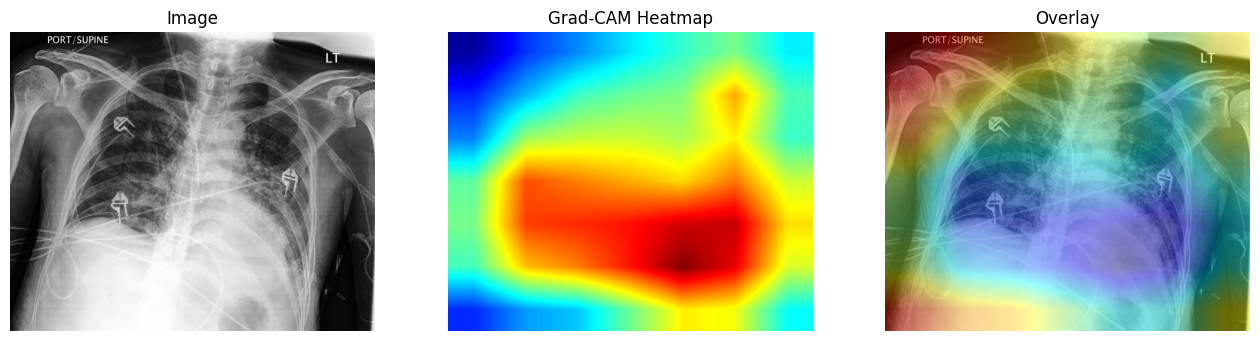

In [26]:
import cv2
import numpy as np
import torch
from torchvision import transforms
import matplotlib.pyplot as plt

# ---------------------------
# Correct full image path
# ---------------------------
img_path = "/root/.cache/kagglehub/datasets/snikhilrao/chexlocalize-dataset/versions/1/chexlocalize_dataset/chexlocalize/CheXpert/val/patient64669/study1/view1_frontal.jpg"

# ---------------------------
# Load image
# ---------------------------
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

tensor_img = transform(img).unsqueeze(0)

# ---------------------------
# Grad-CAM hook
# ---------------------------
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.gradients = None
        self.activations = None

        target_layer.register_forward_hook(self.forward_hook)
        target_layer.register_backward_hook(self.backward_hook)

    def forward_hook(self, module, input, output):
        self.activations = output

    def backward_hook(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def generate(self, class_idx):
        grads = self.gradients.mean(dim=[2, 3], keepdim=True)

        cams = (grads * self.activations).sum(dim=1)[0]
        cams = torch.relu(cams)
        cams = cams / (cams.max() + 1e-8)
        return cams.detach().cpu().numpy()

# ---------------------------
# DENSENET TARGET LAYER
# ---------------------------
# IMPORTANT: DenseNet uses features.denseblock4
target_layer = model.features.denseblock4

cam = GradCAM(model, target_layer)

# ---------------------------
# Forward → Predict class
# ---------------------------
output = model(tensor_img)
class_idx = output.argmax().item()
print("Predicted class index:", class_idx)

# ---------------------------
# Backward on predicted class
# ---------------------------
model.zero_grad()
output[0, class_idx].backward()

heatmap = cam.generate(class_idx)

# ---------------------------
# Make heatmap visible
# ---------------------------
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap_vis = np.uint8(255 * heatmap)
heatmap_vis = cv2.applyColorMap(heatmap_vis, cv2.COLORMAP_JET)

overlay = cv2.addWeighted(img, 0.6, heatmap_vis, 0.4, 0)

# ---------------------------
# Show results
# ---------------------------
plt.figure(figsize=(16,5))

plt.subplot(1,3,1)
plt.imshow(img)
plt.title("Image")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(cv2.cvtColor(heatmap_vis, cv2.COLOR_BGR2RGB))
plt.title("Grad-CAM Heatmap")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(overlay)
plt.title("Overlay")
plt.axis("off")

plt.show()


SEED 42

In [28]:
import torchvision.models as models
import torch.nn as nn
import torch

num_classes = 8

model = models.densenet121(weights=None)
in_features = model.classifier.in_features

# Recreate EXACT classifier used in training
model.classifier = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(in_features, num_classes)
)

checkpoint = torch.load("/content/desenet_seed_42_best_model.pth", map_location="cpu")

# Load the weights
model.load_state_dict(checkpoint["model_state_dict"], strict=True)

model.eval()
print("DenseNet Loaded ✓ (with correct classifier)")


DenseNet Loaded ✓ (with correct classifier)


In [29]:
import os
import pickle
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
from torchvision import transforms
from tqdm import tqdm


# -----------------------------
# Image transform
# -----------------------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])


# ---------------------------------------------------------
# Explainability metrics (NO masks needed)
# ---------------------------------------------------------

def average_drop(orig_score, masked_score):
    return max(0, (orig_score - masked_score) / (orig_score + 1e-6))

def increase_in_conf(orig_score, masked_score):
    return max(0, (masked_score - orig_score) / (orig_score + 1e-6))

def heatmap_entropy(hm):
    hm = hm / (hm.sum() + 1e-6)
    return -np.sum(hm * np.log(hm + 1e-10))

def heatmap_sparsity(hm):
    return 1 - (np.count_nonzero(hm) / hm.size)

def deletion_metric(model, img, hm, steps=30):
    scores = []
    img = img.clone()
    flat = hm.flatten()
    order = np.argsort(-flat)
    mask = torch.ones_like(img)

    for step in range(steps):
        k = int((step + 1) / steps * len(order))

        mask_flat = mask.view(-1)
        mask_flat[order[:k]] = 0
        mask = mask_flat.view_as(mask)

        new_img = img * mask
        with torch.no_grad():
            out = model(new_img.unsqueeze(0))
        scores.append(out.max().item())

    return scores


def insertion_metric(model, img, hm, steps=30):
    scores = []
    blurred = torch.zeros_like(img)
    flat = hm.flatten()
    order = np.argsort(-flat)
    mask = torch.zeros_like(img)

    for step in range(steps):
        k = int((step + 1) / steps * len(order))

        mask_flat = mask.view(-1)
        mask_flat[order[:k]] = 1
        mask = mask_flat.view_as(mask)

        new_img = blurred * (1 - mask) + img * mask

        with torch.no_grad():
            out = model(new_img.unsqueeze(0))
        scores.append(out.max().item())

    return scores


In [30]:
results = []

for patient in tqdm(os.listdir(IMAGE_ROOT)):
    patient_path = os.path.join(IMAGE_ROOT, patient)
    if not patient.startswith("patient"):
        continue

    study_folder = os.path.join(patient_path, "study1")
    img_path = os.path.join(study_folder, "view1_frontal.jpg")

    if not os.path.exists(img_path):
        continue

    heatmap_file = f"{patient}_study1_view1_frontal_Airspace Opacity_map.pkl"
    heatmap_path = os.path.join(HEATMAP_ROOT, heatmap_file)

    if not os.path.exists(heatmap_path):
        continue

    # ---------------------------------------
    # Load image & DenseNet prediction
    # ---------------------------------------
    img = Image.open(img_path).convert("RGB")
    img_t = transform(img).float()

    with torch.no_grad():
        orig_out = model(img_t.unsqueeze(0))
    orig_score = orig_out.max().item()

    # ---------------------------------------
    # Load heatmap (.pkl)
    # ---------------------------------------
    with open(heatmap_path, "rb") as f:
        d = pickle.load(f)

    hm = d["map"]

    # Tensor → NumPy
    if torch.is_tensor(hm):
        hm = hm.detach().cpu().numpy()

    # Remove dims (1,1,H,W → H,W)
    while hm.ndim > 2:
        hm = hm.squeeze()

    hm = hm.astype(float)

    # Normalize 0–1
    hm = (hm - hm.min()) / (hm.max() - hm.min() + 1e-6)

    # Resize to 224×224
    hm = np.array(
        Image.fromarray((hm * 255).astype("uint8")).resize((224, 224))
    ) / 255.0

    # Convert to tensor (1,H,W)
    hm_t = torch.tensor(hm, dtype=torch.float32).unsqueeze(0)

    # ---------------------------------------
    # Masked image (keep only Grad-CAM area)
    # ---------------------------------------
    masked_img = img_t * hm_t

    with torch.no_grad():
        masked_out = model(masked_img.unsqueeze(0).float())
    masked_score = masked_out.max().item()

    # ---------------------------------------
    # Compute metrics
    # ---------------------------------------
    metrics = {
        "patient": patient,
        "avg_drop": average_drop(orig_score, masked_score),
        "inc_conf": increase_in_conf(orig_score, masked_score),
        "entropy": heatmap_entropy(hm),
        "sparsity": heatmap_sparsity(hm),
        "deletion": deletion_metric(model, img_t, hm),
        "insertion": insertion_metric(model, img_t, hm)
    }

    results.append(metrics)


100%|██████████| 200/200 [38:02<00:00, 11.41s/it]


In [31]:
import pandas as pd

df = pd.DataFrame(results)
df.to_pickle("densenet_explainability_results.pkl")
df.to_csv("densenet_explainability_results.csv", index=False)

print("\nSaved:")
print(df.head())



Saved:
        patient  avg_drop  inc_conf    entropy  sparsity  \
0  patient64669  0.286346       0.0   9.984005  0.199956   
1  patient64712  0.368226       0.0  10.126024  0.155931   
2  patient64638  0.065645       0.0  10.234657  0.112663   
3  patient64707  0.307709       0.0   9.649798  0.478815   
4  patient64715  0.250804       0.0  10.212607  0.092056   

                                            deletion  \
0  [8.66801929473877, 8.456355094909668, 8.268043...   
1  [10.42818832397461, 10.072795867919922, 10.023...   
2  [7.110887050628662, 6.301254749298096, 6.15790...   
3  [9.947504043579102, 9.411848068237305, 8.90724...   
4  [7.4439849853515625, 7.567236423492432, 6.7980...   

                                           insertion  
0  [6.6693572998046875, 7.440219402313232, 7.8593...  
1  [6.412598133087158, 6.808364391326904, 7.41683...  
2  [6.202198505401611, 7.4903950691223145, 8.1011...  
3  [6.661386013031006, 7.610977649688721, 8.35331...  
4  [7.0030088424682

In [32]:
import numpy as np
import pandas as pd

df = pd.DataFrame(results)

# ----------------------------
# 1. Scalar metrics aggregated
# ----------------------------
summary = {
    "avg_drop_mean":     df["avg_drop"].mean(),
    "avg_drop_std":      df["avg_drop"].std(),
    "inc_conf_mean":     df["inc_conf"].mean(),
    "inc_conf_std":      df["inc_conf"].std(),
    "entropy_mean":      df["entropy"].mean(),
    "entropy_std":       df["entropy"].std(),
    "sparsity_mean":     df["sparsity"].mean(),
    "sparsity_std":      df["sparsity"].std(),
}

# ----------------------------
# 2. Deletion & insertion curves
# ----------------------------
# Convert list-of-lists → 2D array: shape (N_patients, N_steps)
deletion_array = np.stack(df["deletion"].values)
insertion_array = np.stack(df["insertion"].values)

summary["deletion_curve_mean"] = deletion_array.mean(axis=0).tolist()
summary["insertion_curve_mean"] = insertion_array.mean(axis=0).tolist()

summary["deletion_curve_std"] = deletion_array.std(axis=0).tolist()
summary["insertion_curve_std"] = insertion_array.std(axis=0).tolist()

# Save summary
import json
with open("explainability_dataset_summary.json", "w") as f:
    json.dump(summary, f, indent=4)

print("===== DATASET-LEVEL SUMMARY =====")
for k, v in summary.items():
    if isinstance(v, float):
        print(f"{k}: {v:.5f}")
    else:
        print(f"{k}: (vector length {len(v)})")



===== DATASET-LEVEL SUMMARY =====
avg_drop_mean: 0.24093
avg_drop_std: 0.12655
inc_conf_mean: 0.00142
inc_conf_std: 0.00927
entropy_mean: 10.02331
entropy_std: 0.30369
sparsity_mean: 0.20718
sparsity_std: 0.15163
deletion_curve_mean: (vector length 30)
insertion_curve_mean: (vector length 30)
deletion_curve_std: (vector length 30)
insertion_curve_std: (vector length 30)


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1864: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Predicted class index: 0


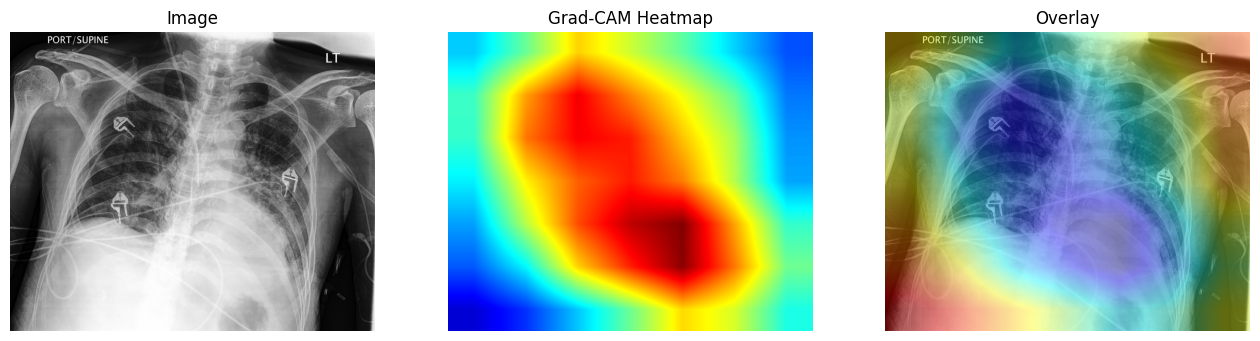

In [33]:
import cv2
import numpy as np
import torch
from torchvision import transforms
import matplotlib.pyplot as plt

# ---------------------------
# Correct full image path
# ---------------------------
img_path = "/root/.cache/kagglehub/datasets/snikhilrao/chexlocalize-dataset/versions/1/chexlocalize_dataset/chexlocalize/CheXpert/val/patient64669/study1/view1_frontal.jpg"

# ---------------------------
# Load image
# ---------------------------
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

tensor_img = transform(img).unsqueeze(0)

# ---------------------------
# Grad-CAM hook
# ---------------------------
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.gradients = None
        self.activations = None

        target_layer.register_forward_hook(self.forward_hook)
        target_layer.register_backward_hook(self.backward_hook)

    def forward_hook(self, module, input, output):
        self.activations = output

    def backward_hook(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def generate(self, class_idx):
        grads = self.gradients.mean(dim=[2, 3], keepdim=True)

        cams = (grads * self.activations).sum(dim=1)[0]
        cams = torch.relu(cams)
        cams = cams / (cams.max() + 1e-8)
        return cams.detach().cpu().numpy()

# ---------------------------
# DENSENET TARGET LAYER
# ---------------------------
# IMPORTANT: DenseNet uses features.denseblock4
target_layer = model.features.denseblock4

cam = GradCAM(model, target_layer)

# ---------------------------
# Forward → Predict class
# ---------------------------
output = model(tensor_img)
class_idx = output.argmax().item()
print("Predicted class index:", class_idx)

# ---------------------------
# Backward on predicted class
# ---------------------------
model.zero_grad()
output[0, class_idx].backward()

heatmap = cam.generate(class_idx)

# ---------------------------
# Make heatmap visible
# ---------------------------
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap_vis = np.uint8(255 * heatmap)
heatmap_vis = cv2.applyColorMap(heatmap_vis, cv2.COLORMAP_JET)

overlay = cv2.addWeighted(img, 0.6, heatmap_vis, 0.4, 0)

# ---------------------------
# Show results
# ---------------------------
plt.figure(figsize=(16,5))

plt.subplot(1,3,1)
plt.imshow(img)
plt.title("Image")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(cv2.cvtColor(heatmap_vis, cv2.COLOR_BGR2RGB))
plt.title("Grad-CAM Heatmap")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(overlay)
plt.title("Overlay")
plt.axis("off")

plt.show()
